# Importing Libraries

In [94]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, DBSCAN, SpectralClustering
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer

# Loading Dataset

In [65]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Analysis

We eliminate all the columns that are either of the following
* Assigned after other values are measured from readings
* Contain ID or name attributes
* Are error attributes

In [66]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [67]:
print(len(TO_USE))
df[TO_USE].head()

19


,koi_fpflag_ec,koi_period,koi_fpflag_ss,koi_teq,koi_steff,dec,koi_fpflag_nt,koi_kepmag,koi_duration,koi_prad,koi_model_snr,koi_insol,ra,koi_fpflag_co,koi_depth,koi_slogg,koi_impact,koi_time0bk,koi_srad
0,0,9.488036,0,793.0,5455.0,48.141651,0,15.347,2.95750,2.26,35.8,93.59,291.93423,0,615.8,4.467,0.146,170.538750,0.927
1,0,54.418383,0,443.0,5455.0,48.141651,0,15.347,4.50700,2.83,25.8,9.11,291.93423,0,874.8,4.467,0.586,162.513840,0.927
2,0,19.899140,1,638.0,5853.0,48.134129,0,15.436,1.78220,14.60,76.3,39.30,297.00482,0,10829.0,4.544,0.969,175.850252,0.868
3,0,1.736952,1,1395.0,5805.0,48.285210,0,15.597,2.40641,33.46,505.6,891.96,285.53461,0,8079.2,4.564,1.276,170.307565,0.791
4,0,2.525592,0,1406.0,6031.0,48.226200,0,15.509,1.65450,2.75,40.9,926.16,288.75488,0,603.3,4.438,0.701,171.595550,1.046


# Extracting Dataframe Subset

We extract only those rows which are `CONFIRMED` examples i.e. the `disposition value` is `CONFIRMED`.

In [68]:
df = df[df["koi_disposition"] == "CONFIRMED"]
df = df[TO_USE]
print(df.shape)
df.head()

(2292, 19)


,koi_fpflag_ec,koi_period,koi_fpflag_ss,koi_teq,koi_steff,dec,koi_fpflag_nt,koi_kepmag,koi_duration,koi_prad,koi_model_snr,koi_insol,ra,koi_fpflag_co,koi_depth,koi_slogg,koi_impact,koi_time0bk,koi_srad
0,0,9.488036,0,793.0,5455.0,48.141651,0,15.347,2.9575,2.26,35.8,93.59,291.93423,0,615.8,4.467,0.146,170.53875,0.927
1,0,54.418383,0,443.0,5455.0,48.141651,0,15.347,4.5070,2.83,25.8,9.11,291.93423,0,874.8,4.467,0.586,162.51384,0.927
4,0,2.525592,0,1406.0,6031.0,48.226200,0,15.509,1.6545,2.75,40.9,926.16,288.75488,0,603.3,4.438,0.701,171.59555,1.046
5,0,11.094321,0,835.0,6046.0,48.224670,0,15.714,4.5945,3.90,66.5,114.81,296.28613,0,1517.5,4.486,0.538,171.20116,0.972
6,0,4.134435,0,1160.0,6046.0,48.224670,0,15.714,3.1402,2.77,40.2,427.65,296.28613,0,686.0,4.486,0.762,172.97937,0.972


# Extracting Values

In [98]:
X = df.values
#X = StandardScaler().fit_transform(X)
#X = MinMaxScaler().fit_transform(X)

# KMeans Clustering

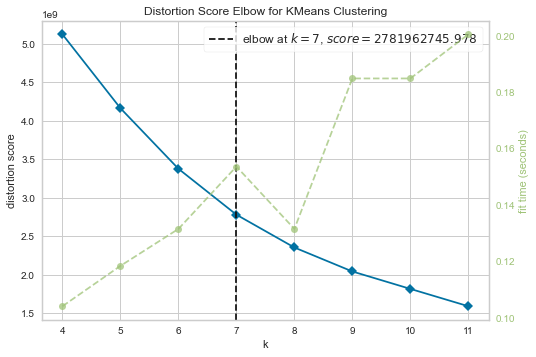

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(X)
visualizer.show()

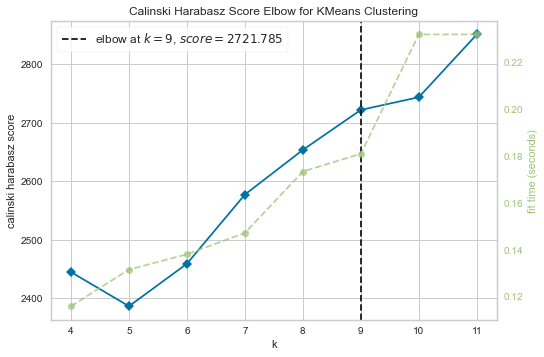

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [100]:
visualizer = KElbowVisualizer(model, k=(4,12), metric="calinski_harabasz")
visualizer.fit(X)
visualizer.show()

In [101]:
K=7
model = KMeans(K, max_iter=500, random_state=0)

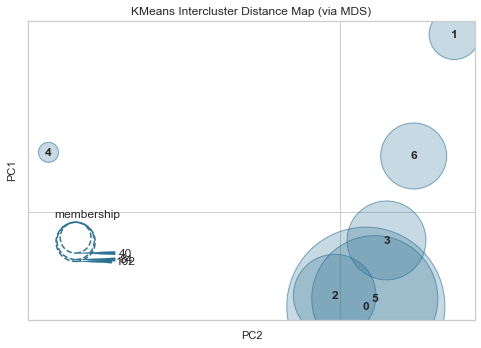

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [102]:
visualizer = InterclusterDistance(model)
visualizer.fit(X)
visualizer.show()

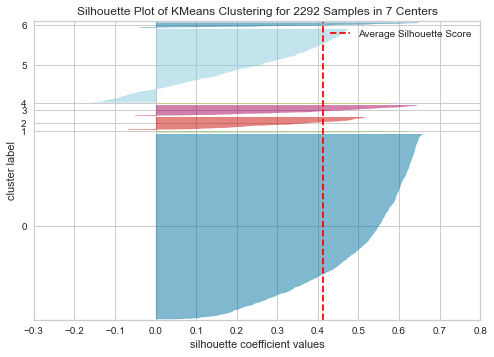

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2292 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [103]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

# Agglomerative Clustering

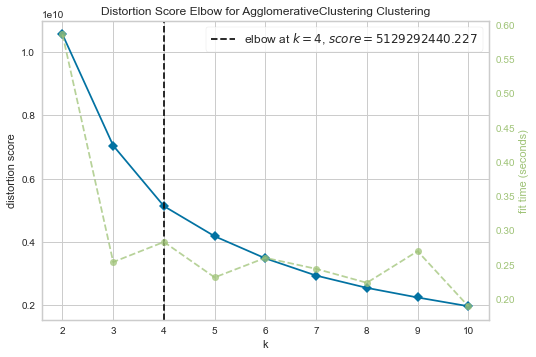

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [104]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, n_clusters=(4,12))
visualizer.fit(X)
visualizer.show()

In [106]:
K=5
model = AgglomerativeClustering(n_clusters=K)

In [121]:
'''visualizer = InterclusterDistance(model)
visualizer.fit(X)
visualizer.show()'''

'visualizer = InterclusterDistance(model)\nvisualizer.fit(X)\nvisualizer.show()'

In [120]:
'''visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()'''

"visualizer = SilhouetteVisualizer(model, colors='yellowbrick')\nvisualizer.fit(X)\nvisualizer.show()"

# Birch

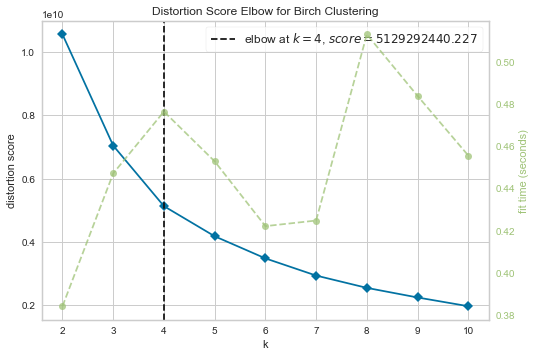

<AxesSubplot:title={'center':'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [111]:
model = Birch()
visualizer = KElbowVisualizer(model, n_clusters=(4,12))
visualizer.fit(X)
visualizer.show()

In [112]:
K=4
model = Birch(n_clusters=K)

In [119]:
'''visualizer = InterclusterDistance(model)
visualizer.fit(X)
visualizer.show()'''

'visualizer = InterclusterDistance(model)\nvisualizer.fit(X)\nvisualizer.show()'

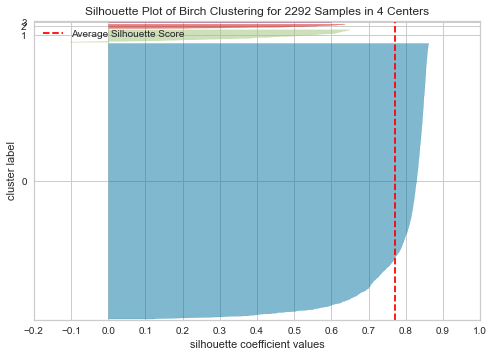

<AxesSubplot:title={'center':'Silhouette Plot of Birch Clustering for 2292 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [114]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

# DBSCAN

In [122]:
model = DBSCAN()
visualizer = KElbowVisualizer(model, eps=(0,10))
visualizer.fit(X)
visualizer.show()

ValueError: Invalid parameter n_clusters for estimator DBSCAN(). Check the list of available parameters with `estimator.get_params().keys()`.

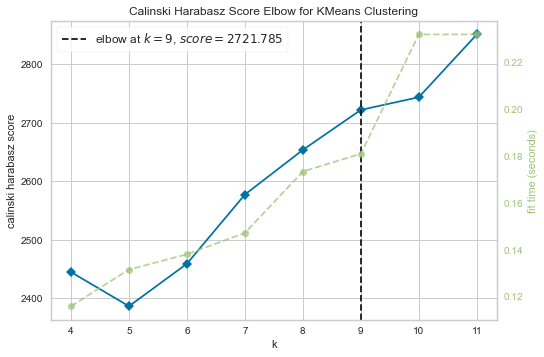

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [100]:
visualizer = KElbowVisualizer(model, k=(4,12), metric="calinski_harabasz")
visualizer.fit(X)
visualizer.show()

In [123]:
K=7
model = DBSCAN()

AttributeError: 'DBSCAN' object has no attribute 'cluster_centers_'

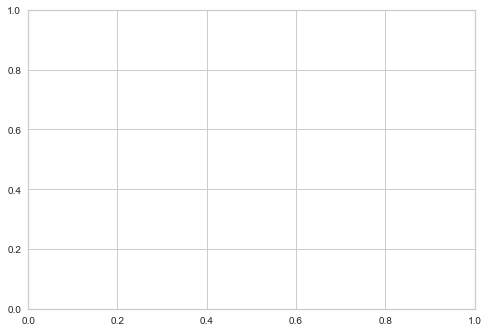

In [124]:
visualizer = InterclusterDistance(model)
visualizer.fit(X)
visualizer.show()

In [125]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

AttributeError: 'DBSCAN' object has no attribute 'n_clusters'